In [18]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
print(f'torch version: {torch.__version__}')

#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

torch version: 1.13.0
using device: cuda


In [19]:
# brain-mri-images-for-brain-tumor-detection
import requests
import zipfile
from pathlib import Path
import os

# Setup path to data folder
data_path = Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset")

for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset'.
There are 0 directories and 98 images in '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/no'.
There are 0 directories and 155 images in '/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes'.


In [20]:
no_path = data_path/'no'
yes_path = data_path/'yes'


Random image path: /kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset/yes/Y53.jpg
Image class: Y53
Image height: 219
Image width: 230


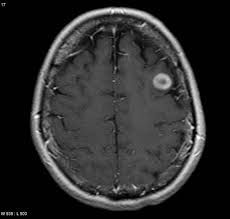

In [21]:
import random
from PIL import Image

# Set seed
random.seed(6) # <- try changing this and see what happens
image_path_list = list(data_path.glob("*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.stem
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

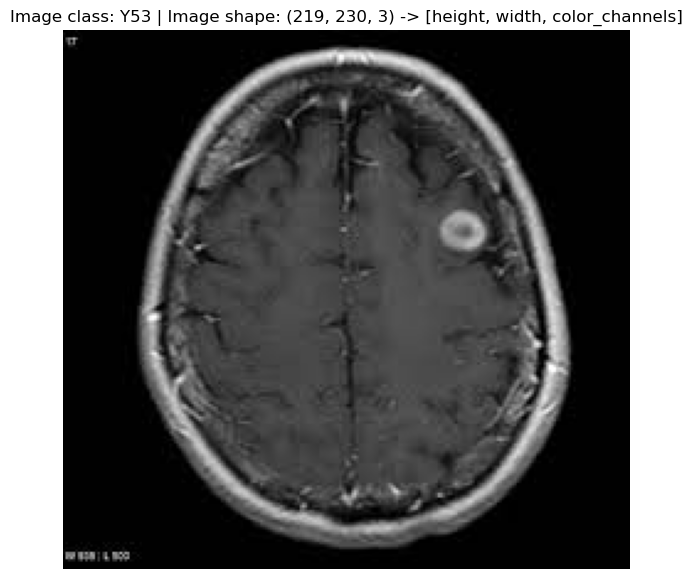

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)
# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [23]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List
from PIL import Image, ImageOps


# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        #removing paths with 4 colour channels i.e. (454, 442, 4), (there is 5 such examples)
        for path in self.paths:
            img = Image.open(path) 
            size = np.asarray(img).shape
            if len(size) >= 3 and size[-1] > 3:
                self.paths.remove(path)
        
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        self.classes, self.class_to_idx = ['yes', 'no'], {'yes': 1, 'no': 0}

    # 4. Make function to load images (not required)
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        opened = Image.open(image_path)
        if np.asarray(opened).ndim > 2:
            return opened
        else:
            #Dealing with 2 dimensional inputs (expanding to 3d with 3 colour channels)
            np_array = np.asarray(opened)
            torch_unsqueezed = torch.tensor(np_array).unsqueeze(dim=2)
            np_array_formatted = np.uint8(torch_unsqueezed.numpy())
            colours_channels_3= np.concatenate((np_array_formatted, np_array_formatted, np_array_formatted), axis = 2)
            opened = Image.fromarray(colours_channels_3.astype(np.uint8))
            return opened
           
           
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            transformed_img = self.transform(img)
            return transformed_img, class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)

In [24]:
full_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=3)])

data_path = Path("/kaggle/input/brain-mri-images-for-brain-tumor-detection/brain_tumor_dataset")
full_dataset = ImageFolderCustom(targ_dir=data_path, 
                                 transform=full_transforms)
full_dataset

[20, 124, 66, 9, 0, 37, 150, 120, 95, 81]


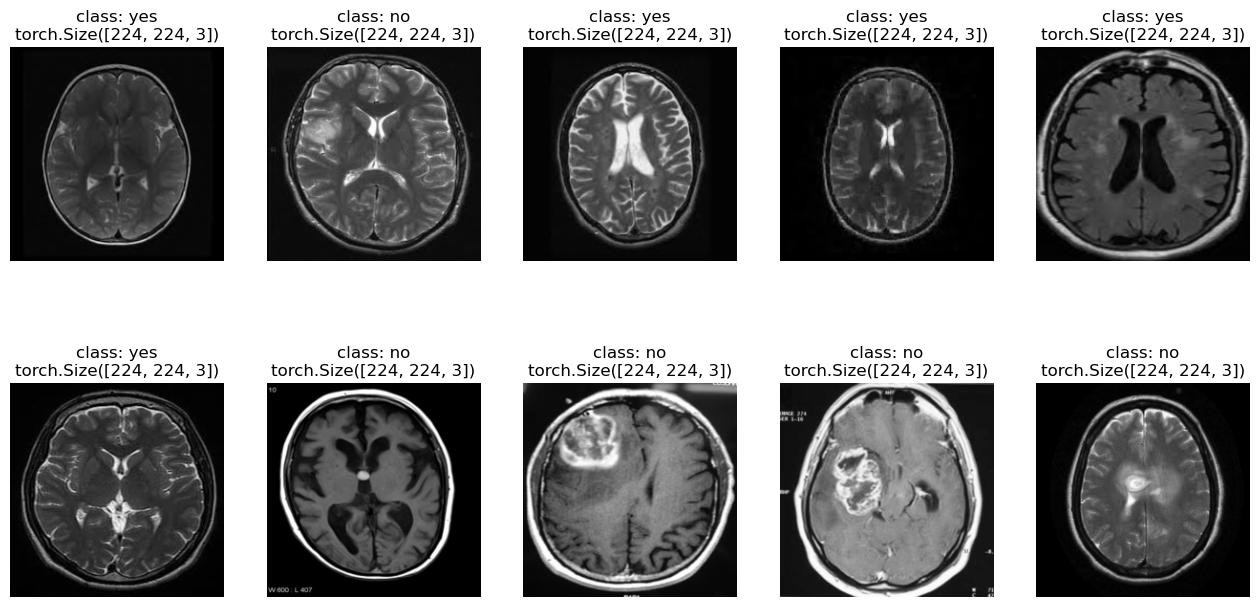

In [25]:
classes = full_dataset.classes
random_samples_idx = random.sample(range(len(full_dataset)), k=10)
print(random_samples_idx)
plt.figure(figsize=(16, 8))
for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = full_dataset[targ_sample][0], full_dataset[targ_sample][1]
    targ_image_adjust = targ_image.permute(1, 2, 0)
    plt.subplot(2, 5, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
        title = f"class: {classes[targ_label]}"
        title = title + f"\n{targ_image_adjust.shape}"
    plt.title(title)

In [26]:
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
print(f'len(train_dataset): {len(train_dataset)}, len(test_dataset): {len(test_dataset)}')
from torch.utils.data import DataLoader

BATCH_SIZE = 8

train_dataloader = DataLoader(dataset=train_dataset, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                     num_workers=0, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_dataset, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    num_workers=0, 
                                    shuffle=False) # don't usually need to shuffle testing data

print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {BATCH_SIZE}")

train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(test_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
print(test_features_batch.shape, test_labels_batch.shape)

len(train_dataset): 132, len(test_dataset): 34
Length of train_dataloader: 17 batches of size 8
Length of test_dataloader: 5 batches of size 8
torch.Size([8, 3, 224, 224]) torch.Size([8])
torch.Size([8, 3, 224, 224]) torch.Size([8])


In [27]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [28]:
import torchvision

weights = torchvision.models.ResNet50_Weights.DEFAULT
model = torchvision.models.resnet50(weights=weights).to(device)
# weights.transforms()
#Ideally should apply these transformations to the training dataset
#Will likely come back to see if this improves performance later on


In [29]:
#Freezing all layers of the network apart from the last fully connected one (which we'll delete)
layers_to_freeze = [model.conv1, model.bn1, model.layer1, model.layer2, model.layer3, model.layer4]
for layer in layers_to_freeze:
    for param in layer.parameters():
        param.requires_grad = False

In [35]:
model.fc = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=2048, 
                    out_features=1, # same number of output units as our number of classes
                    bias=True),
    nn.Sigmoid()).to(device)

In [36]:
train_features_batch.shape, train_labels_batch.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [37]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params = model.parameters(),
                             lr = 0.001) #weight_decay = 1e-8
# optimizer = torch.optim.SGD(params, lr=0.1, momentum=0.9)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 110)

In [38]:

train_features_batch = train_features_batch.to(device)
train_labels_batch = train_labels_batch.type(torch.float32).to(device)
y_pred = model(train_features_batch).squeeze()

loss = loss_fn(y_pred, train_labels_batch)
loss

tensor(0.7111, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [39]:
from tqdm.auto import tqdm #progress bar
import time
t1 = time.time()
lrs = []
train_loss_graph = []
test_loss_graph = []

train_accuracy_graph = []
test_accuracy_graph = []

epochs = 5
batch = -1 # incase we move evaluation indentation
# for epoch in tqdm(range(epochs)):
for epoch in range(epochs):
    for batch, (X, y) in enumerate(train_dataloader):
        batch_time = time.time()
        X = X.to(device)
        y = y.to(device)
        y = y.type(torch.float32)
        
        model.train()
        #1. Forward pass
        y_pred = model(X).squeeze()
        #2 Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backward
        loss.backward()
        #5. Optimizer step
        optimizer.step()
        
        #Evaluating model
        model.eval()  
#         if batch % 5 == 0:
        train_loss = 0
        test_loss = 0
        train_acc = 0
        test_acc = 0

        train_count = 0
        test_count = 0

        with torch.inference_mode(): #context manager
            for X_t, y_t in train_dataloader:
                X_t = X_t.to(device)
                y_t = y_t.to(device)
                y_t = y_t.type(torch.float32)

                y_t_pred = model(X_t).squeeze()
                loss_t = loss_fn(y_t_pred, y_t)
                train_loss+=loss_t #accumulate train loss
                train_acc+=torch.round(y_t_pred).sum().item()
                #print(f"{torch.round(y_t_pred).sum().item()}/{X_t.shape[0]} elements predicted in train")
                train_count+=X_t.shape[0]

            for X_t, y_t in test_dataloader:
                X_t = X_t.to(device)
                y_t = y_t.to(device)
                y_t = y_t.type(torch.float32)

                y_t_pred = model(X_t).squeeze()
                loss_t = loss_fn(y_t_pred, y_t)
                test_loss+=loss_t #accumulate train loss
                test_acc+=torch.round(y_t_pred).sum().item()
                test_count+=X_t.shape[0]

            train_loss /= train_count
            test_loss /= test_count

            train_acc /= train_count
            test_acc /= test_count

            train_loss_graph.append(train_loss)
            test_loss_graph.append(test_loss)

            train_accuracy_graph.append(train_acc)
            test_accuracy_graph.append(test_acc)

            cur_lr = optimizer.param_groups[0]["lr"]
            print(f"Epoch: {epoch}, batch {batch}, taken {time.time()-batch_time:.4f} seconds | Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | Test loss: {test_loss:.4f}, acc: {test_acc:.4f} | Learning rate: {cur_lr:.6f}")
            
            
            
    lrs.append(optimizer.param_groups[0]["lr"])
#     scheduler.step()
            
print(f'Taken {float(time.time()-t1):.5f} seconds.')

Epoch: 0, batch 0, taken 1.3065 seconds | Train loss: 0.0906, acc: 0.2348 | Test loss: 0.1025, acc: 0.4412 | Learning rate: 0.001000
Epoch: 0, batch 1, taken 1.3190 seconds | Train loss: 0.0897, acc: 0.3712 | Test loss: 0.1035, acc: 0.5882 | Learning rate: 0.001000
Epoch: 0, batch 2, taken 1.4828 seconds | Train loss: 0.0891, acc: 0.6515 | Test loss: 0.1048, acc: 0.8824 | Learning rate: 0.001000
Epoch: 0, batch 3, taken 1.2889 seconds | Train loss: 0.0889, acc: 0.6515 | Test loss: 0.1044, acc: 0.8824 | Learning rate: 0.001000
Epoch: 0, batch 4, taken 1.2867 seconds | Train loss: 0.0884, acc: 0.6894 | Test loss: 0.1046, acc: 0.8235 | Learning rate: 0.001000
Epoch: 0, batch 5, taken 1.2831 seconds | Train loss: 0.0884, acc: 0.6515 | Test loss: 0.1049, acc: 0.7941 | Learning rate: 0.001000
Epoch: 0, batch 6, taken 1.3495 seconds | Train loss: 0.0878, acc: 0.6818 | Test loss: 0.1050, acc: 0.7941 | Learning rate: 0.001000
Epoch: 0, batch 7, taken 1.2914 seconds | Train loss: 0.0876, acc: 0.

KeyboardInterrupt: 

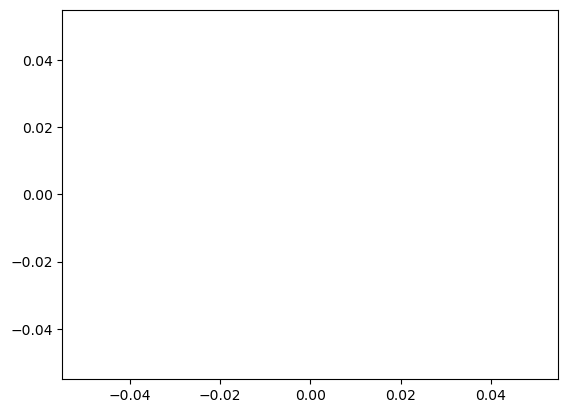

In [40]:
# Only have. len(train_dataset): 132, len(test_dataset): 34
# Very hard ot generate good results with such a small dataset.
plt.plot(lrs)

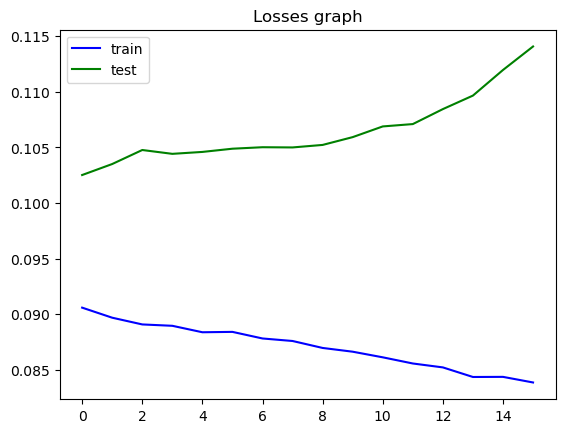

In [48]:
plt.plot([x.cpu() for x in train_loss_graph], color = 'blue', label = 'train')
plt.plot([x.cpu() for x in test_loss_graph], color = 'green', label = 'test')
plt.title("Losses graph")
plt.legend(loc="upper left")
plt.show()

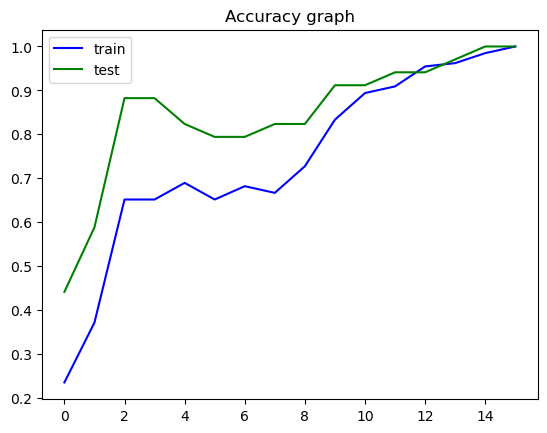

In [47]:
plt.plot(train_accuracy_graph, color = 'blue', label = 'train')
plt.plot(test_accuracy_graph, color = 'green', label = 'test')
plt.title("Accuracy graph")
plt.legend(loc="upper left")
plt.show()

In [ ]:
summary(model=model, 
        input_size=(8, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])